**Image segmentation as a st-min cut problem :**
- Graph with nodes:
    - 1 source --> Foreground
    - 1 sink --> Background
    - Pixels
- Edges :
    - probability of i being background : -log(abs(I[i,j] - Ibmean)/(abs(I[i,j] - Ifmean)+abs(I[i,j] - Ibmean)))
    - weight from sink to i: probabilty of i being background/sum of probabilities
    - weight from source to i: probabilty of i being foreground/sum of probabilities
    - Edges between two pixels : weight from i to a 4-neighbourhood pixel:
                                K * e−|Ii−Ij|2 / s
                                 where k and s are parameters that determine hwo close the neighboring pixels are how fast the values
                                 decay towards zero with increasing dissimilarity  
                                 --> care different cases for left (only right, top, pixels, right, top and bottom pixels
--> Create the graph as it was in the other file

--> Implement Ford Fulkerson graph cut to get the residential to get the min-cut.

--> From the residual graph, you can get the min cut! Nodes can only be linked with the sink and not with the source, seek on this tomorrow

In [ ]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

gamma = 0.001
fore = (225,142,279,185)
back = (7,120,61,163)

class Graph:
    def __init__(self, sink_node):
        self.source_node = sink_node-1
        self.sink_node = sink_node
        self.graph = np.zeros((sink_node+1, sink_node+1))
        self.ROW = sink_node + 1
    
    def add_terminal_edge(self, node, source_weight, sink_weight):
        self.graph[self.source_node][node] = source_weight
        self.graph[node][self.sink_node] = sink_weight
    
    def add_edge(self, node1, node2, weight):
        self.graph[node1][node2] = weight
    
    '''Returns true if there is a path from source 's' to sink 't' in 
    residual graph. Also fills parent[] to store the path '''
    def BFS(self,s, t, parent): 
  
        # Mark all the vertices as not visited 
        visited =[False]*(self.ROW) 
          
        # Create a queue for BFS 
        queue=[] 
          
        # Mark the source node as visited and enqueue it 
        queue.append(s) 
        visited[s] = True
           
         # Standard BFS Loop 
        while queue: 
  
            #Dequeue a vertex from queue and print it
            u = queue.pop(0) 
          
            # Get all adjacent vertices of the dequeued vertex u 
            # If a adjacent has not been visited, then mark it 
            # visited and enqueue it 
            for ind, val in enumerate(self.graph[u]): 
                if visited[ind] == False and val > 0 : 
                    queue.append(ind) 
                    visited[ind] = True
                    parent[ind] = u 
  
        # If we reached sink in BFS starting from source, then return 
        # true, else false 
        return True if visited[t] else False
              
      
    # Returns the maximum flow from s to t in the given graph 
    def FordFulkerson(self, source, sink): 
  
        # This array is filled by BFS and to store path 
        parent = [-1]*(self.ROW) 
  
        max_flow = 0 # There is no flow initially 
  
        # Augment the flow while there is path from source to sink 
        while self.BFS(source, sink, parent) : 
  
            # Find minimum residual capacity of the edges along the 
            # path filled by BFS. Or we can say find the maximum flow 
            # through the path found. 
            path_flow = float("Inf") 
            s = sink 
            while(s !=  source): 
                path_flow = min(path_flow, self.graph[parent[s]][s]) 
                s = parent[s] 
  
            # Add path flow to overall flow 
            max_flow +=  path_flow 
  
            # update residual capacities of the edges and reverse edges 
            # along the path 
            v = sink 
            while(v !=  source): 
                u = parent[v] 
                self.graph[u][v] -= path_flow 
                v = parent[v] 
  
        return max_flow, self.graph
  
        

def create_graph_from_images(img_path, gamma, fore, back):
    I = (Image.open(img_path).convert('L')) # read image

    If = I.crop(fore) # take a part of the foreground
    Ib = I.crop(back) # take a part of the background
    I,If,Ib = np.array(I),np.array(If),np.array(Ib) # convert all the images to arrays to calculation
    
    hist_if = cv2.calcHist([If],[0],None,[256],[0,256])
    hist_ib = cv2.calcHist([Ib],[0],None,[256],[0,256])
    
    Ifmean = np.argmax(hist_if)
    Ibmean = np.argmax(hist_ib)
    
    Im = I.copy().flatten().astype('int') #Coverting the image array to a vector for ease.
    m,n = I.shape[0],I.shape[1] # copy the size
    
    source_node = m*n
    sink_node = m*n+1
    
    graph = Graph(sink_node)
    
    # Define the probability with background and foreground
    F = np.zeros(I.shape)
    B = np.zeros(I.shape)
    
    for i in range(I.shape[0]): # Defining the Probability function....
        for j in range(I.shape[1]):
            diff_back = abs(I[i,j] - Ifmean)
            diff_fore = abs(I[i,j] - Ibmean)   
            den = diff_back + diff_fore
            
            # Probability of a pixel being foreground
            if diff_fore > 0:
                F[i,j] = -np.log(diff_fore/den) 
            else:
                F[i,j] = 100
            
            # Probability of a pixel being background
            if diff_back > 0:
                B[i,j] = -np.log(diff_back/den) 
            else:
                B[i, j]= 100

    F,B = F.flatten(), B.flatten() # convertingb  to column vector for ease
        
    for i in range(m*n): #checking the 4-neighborhood pixels
        ws=(F[i]/(F[i]+B[i])) # source weight
        wt=(B[i]/(F[i]+B[i])) # sink weight
        graph.add_terminal_edge(i, ws, wt)
        
        pixels_to_update = [i-1, i+1, i-n, i+n]
        
        for pixel_to_update in pixels_to_update:
            if 0 <= pixel_to_update < m*n:
                weight = np.exp(-gamma*((abs(Im[i]-Im[pixel_to_update])**2)))
                graph.add_edge(i, pixel_to_update, weight)
    
    max_flow, res_graph = graph.FordFulkerson(source_node, sink_node)
    
    print(f'max_flow is {max_flow}')
        
create_graph_from_images('input1.jpeg', gamma, fore, back)

In [3]:
import networkx as nx

In [10]:
G = nx.DiGraph()
G.add_edge("x", "a", capacity=2.0)
G.add_edge("x", "b", capacity=4.0)
G.add_edge("a", "b", capacity=3.0)
G.add_edge("a", "y", capacity=1.0)
G.add_edge("b", "y", capacity=2.0)


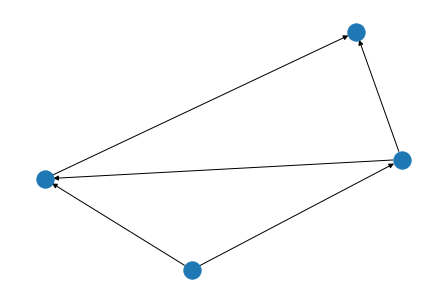

In [34]:
nx.draw(G)

In [32]:
res_graph = nx.algorithms.flow.boykov_kolmogorov(G, 'x', 'y', 'capacity')

In [36]:
print(res_graph.graph['trees'])

({'x': None, 'a': 'x', 'b': 'x'}, {'y': None})


In [39]:
source_tree, target_tree = res_graph.graph["trees"]
partition = (set(source_tree), set(G) - set(source_tree))

In [40]:
partition

({'a', 'b', 'x'}, {'y'})